# Gerardo de Miguel González

**::GMG::** The aim of this notebook is to find a basic workflow for doing machine learning classification of an imbalanced dataset using best practices taken from other people's examples.

# Binary Classification Proof of Concept

## References

**::GMG::** These are the references I've followed:

  - [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall) Precision and Recall
  - [Classifier evaluation with imbalanced datasets](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) Introduction to the precision-recall plot.
  - [saito2015a](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432) Takaya Saito and Marc Rehmsmeier (2015) The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets. PLoS One. 10(3):e011843.
  - [Acute Care Testing](https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used) Precision-recall curves – what are they and how are they used? by Suzanne Ekelund, 2017.
  - [Python Machine Learning](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python by Jason Brownlee on August 31, 2018.

`Brownlee (2018)` states clearly the evaluation curve I must use:

> When to Use ROC vs. Precision-Recall Curves?
>
>Generally, the use of ROC curves and precision-recall curves are as follows:
>
>  1. ROC curves should be used when there are roughly equal numbers of observations for each class.
>  2. Precision-Recall curves should be used when there is a moderate to large class imbalance.

that is fully supported by `Saito2015a` paper in PLoS One.

## Libraries

In [1]:
#::GMG::Basic Dataset Management: dataframes and ndarrays
import pandas as pd
import numpy as np

In [2]:
#::GMG::seaborn: statistical data visualization for a heatmap of pandas.corr()
#::NOTE::There's a lot of fuss for 'heatmapping' with matplotlib only
# https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#::GMG::Logistic Regression (aka logit) for classification
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression

In [4]:
#::GMG::Split train and test
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection
from sklearn.model_selection import train_test_split

In [5]:
#::GMG::basic accuracy metric
# https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score
from sklearn.metrics import accuracy_score

In [6]:
#::GMG::ROC/AUC
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
from sklearn.metrics import roc_curve, roc_auc_score 

In [7]:
#::GMG::etrics suited for imbalanced datasets
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, balanced_accuracy_score

In [8]:
#::GMG::confusion matrix and one report for all metrics 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
#::GMG::For pre-processing not conmensurate features
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-data
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

## Dataset

### load

**::GMG::** The dataset *was available* in [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) but there's only [a text file](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/) with a notice at the moment what reads:

*Thank you for your interest in the Pima Indians Diabetes dataset. 
The dataset is no longer available due to permission restrictions.*

**::GMG::** There are alternatives to downloading the csv formatted file though. I'm not sure whether those alternatives are going to keep being available in the near future. The first alternative that I've found out allows a direct download of a csv formated raw data, without any metadata (header):

  - [networkrepository.com](http://networkrepository.com/pima-indians-diabetes.php)
  
However you can read metadata info and citation policy in the web page. The website also provides tools for interactive exploration of data. You can visualize and interactively explore pima-indians-diabetes and its important statistics.

```BibText
@inproceedings{nr,
     title={The Network Data Repository with Interactive Graph Analytics and Visualization},
     author={Ryan A. Rossi and Nesreen K. Ahmed},
     booktitle={AAAI},
     url={http://networkrepository.com},
     year={2015}
}
```

**::NOTE::** I don't know how to deal with [Bibtext](https://en.wikipedia.org/wiki/BibTeX) bibliographic entries in Notebooks yet.

**::GMG::** You may also [download the data from kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database/downloads/pima-indians-diabetes-database.zip/1) in zipped csv format (which *includes a header* with the column names by the way) using [the reference provided](https://www.kaggle.com/uciml/pima-indians-diabetes-database) in the Datacamp article *if you have an account in kaggle*. I haven't checked it but you should be able [to use the kaggle API](https://medium.com/@yvettewu.dw/tutorial-kaggle-api-google-colaboratory-1a054a382de0) to automate the download from code *with an API key* created with your account. 

**::GMG::** Scikit learn has a [module for reference datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) in its API. Some of the API calls let you *fetch datasets* from platforms like [openml](https://www.openml.org/), i.e [`sklearn.datasets.fetch_openml`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html). You only need  to know the [openml reference ID](https://www.openml.org/d/37) for the database in openml.

**::GMG::** I've already downloaded the csv dataset *manually from kaggle* (with my account  and placed it in a data folder.

In [10]:
!ls data

pima-indians-diabetes.csv


In [11]:
#::GMG::Dataframe from csv file
data = pd.read_csv("data/pima-indians-diabetes.csv")

In [12]:
#::GMG::Check the first samples
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [13]:
#::GMG::Check the last samples
data.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


**::GMG::** There are 8 different integer and real features and the categorical (binary) *Outcome* (i.e. classification) where 1 stands for having diabetes, and 0 denotes not havving diabetes

In [14]:
print("Diabetes data set dimensions : {}".format(data.shape))

Diabetes data set dimensions : (768, 9)


### exploratory data analysis

In [15]:
#::GMG::See what data types have features and target
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [16]:
#::GMG::Statistics of features and target 
# ::NOTE::Glucose, BloodPressure, SkinThickness, Insulin and BMI 
#       have ZEROS (min statistic) in their values ... 
#
#::NOTE::The features are not commensurate, I mean, some of them need scaling/normalization/standarization
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


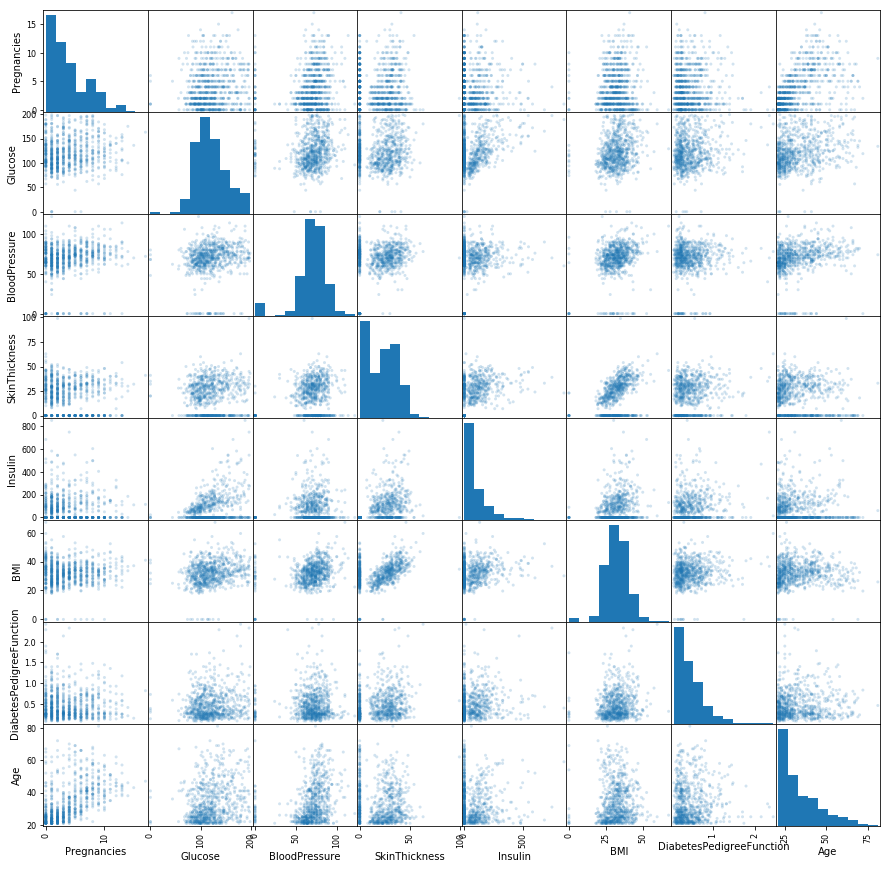

In [17]:
#::GMG::Visualization: a pandas scatterplot matrix
# https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781784390150/4/ch04lvl1sec37/a-scatter-plot-matrix
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
# https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#plotting-tools
spm = pd.plotting.scatter_matrix(
        data.iloc[:,:data.shape[1] - 1], figsize=(15, 15), alpha=0.2, diagonal='hist'
)

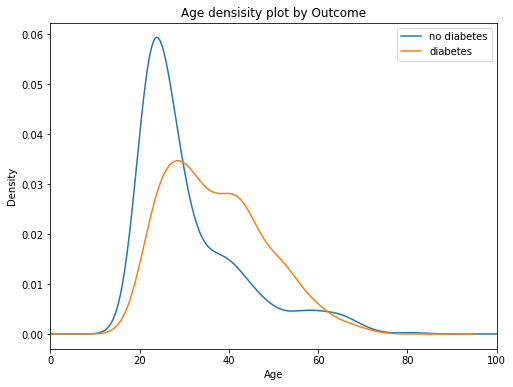

In [18]:
#::GMG::I can also see density plots of individual features by Outcome
# https://stackoverflow.com/questions/28293028/plotting-grouped-data-in-same-plot-using-pandas
# https://stackoverflow.com/questions/43463438/how-to-plot-multiple-density-plots-on-the-same-figure-in-python/43463947
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Age densisity plot by Outcome')
ax.set_xlabel('Age')
ax.set_xlim(0, 100)
label = ['no diabetes', 'diabetes']
for i, df in data.groupby('Outcome'):
    df.Age.plot(kind="kde", ax=ax, label=label[i])
ax.legend()

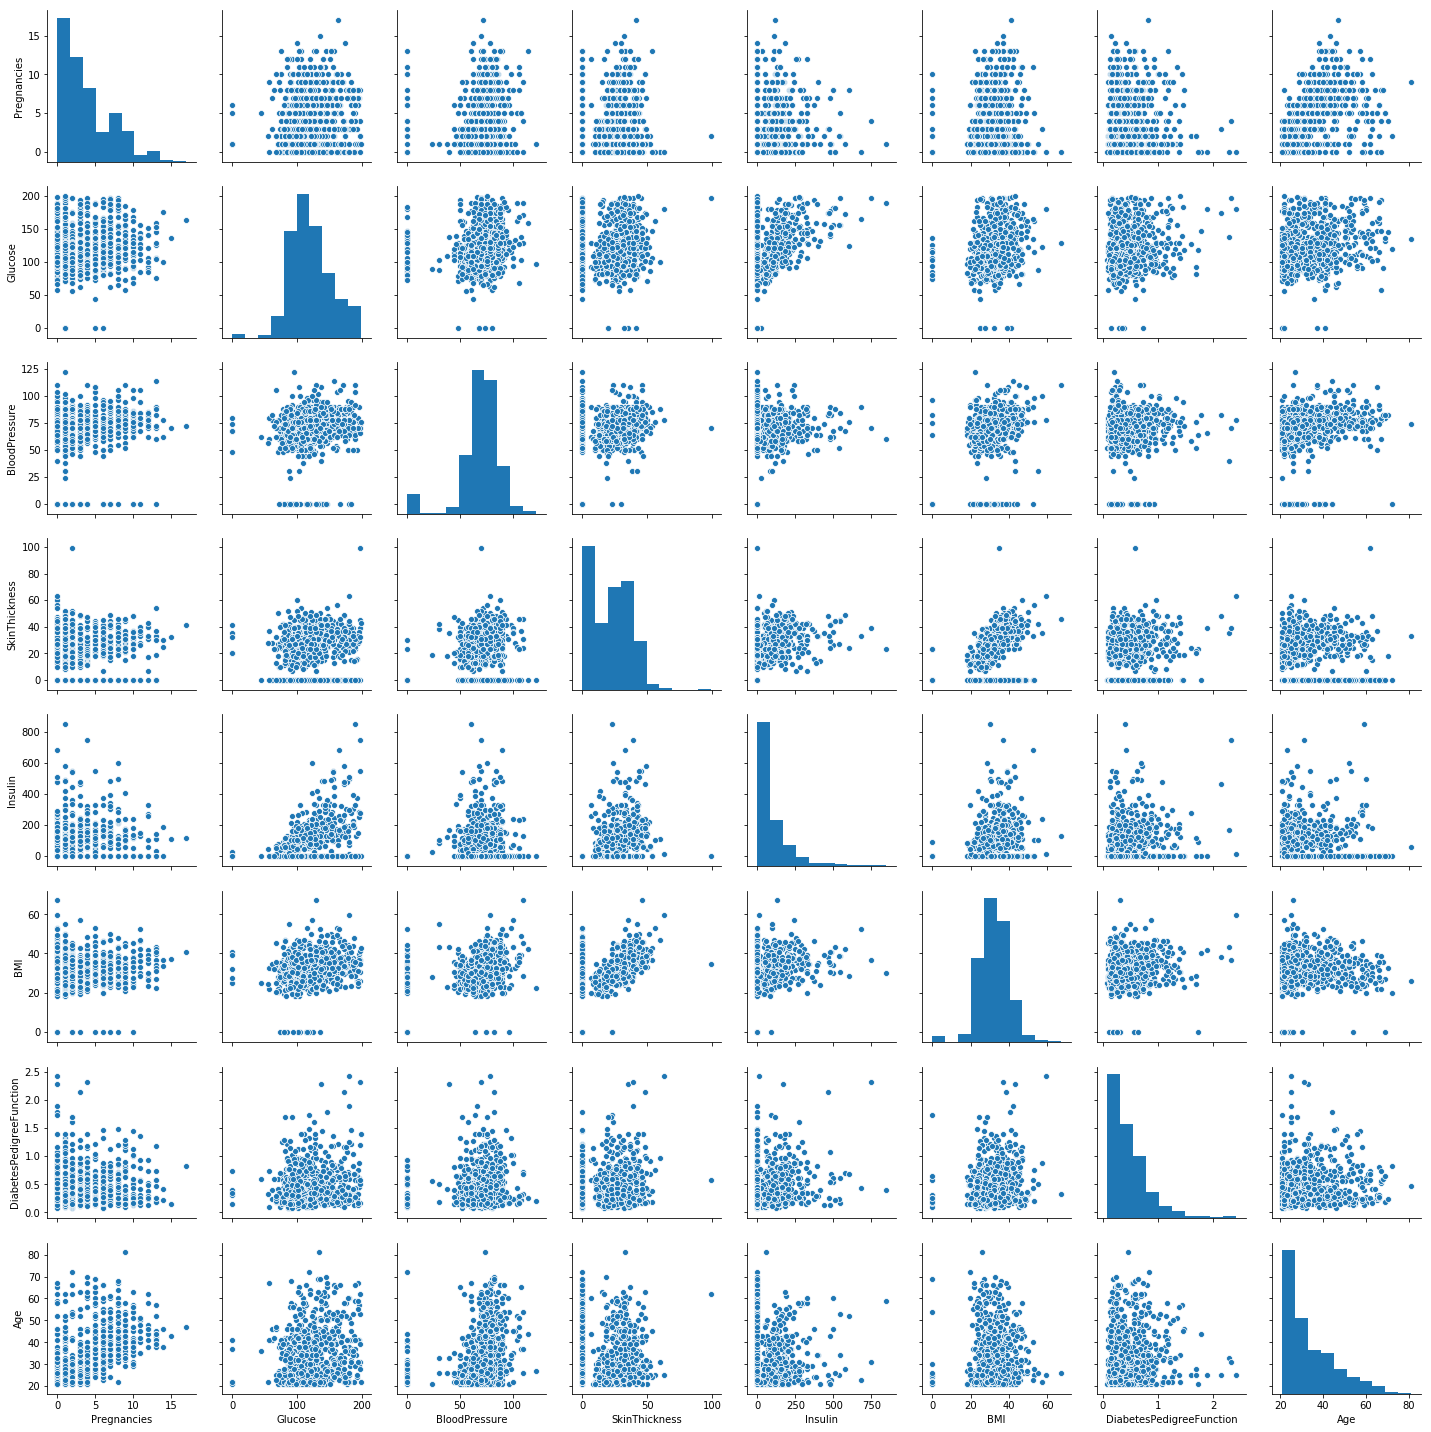

In [19]:
#::GMG::Seaborn's pairplot looks prettier
# https://seaborn.pydata.org/examples/scatterplot_matrix.html
sns.pairplot(data = data.iloc[:,:data.shape[1] - 1])

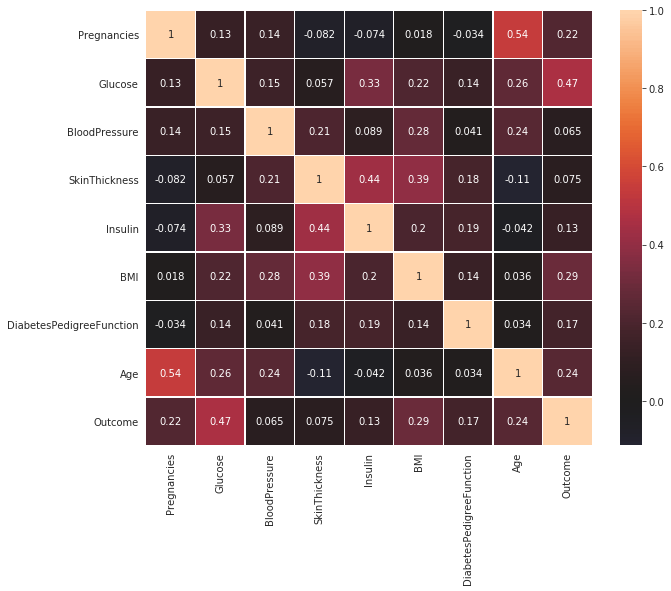

In [20]:
#::GMG::Not much insight from these corr() numbers
color = sns.color_palette()
sns.set_style('darkgrid')
plt.subplots(figsize=(10,8))
sns.heatmap(data.corr(), center=0, annot=True, linewidths=.3)

In [21]:
#::GMG::Beware of the imbalance dataset ...
#       https://www.quora.com/What-is-an-imbalanced-dataset
#       https://www.datacamp.com/community/tutorials/diving-deep-imbalanced-data
#       https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
#       How do I check?
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
data.groupby('Outcome').size()

Outcome
0    500
1    268
dtype: int64

Text(0, 0.5, 'Frequency %')

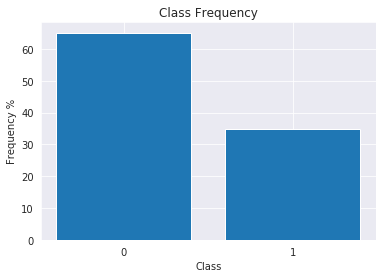

In [22]:
#::GMG::Say, 0 healthy, 1 diabetes
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.chararray.astype.html
# https://matplotlib.org/gallery/lines_bars_and_markers/categorical_variables.html
classes = data.Outcome.values
unique, counts = np.unique(classes, return_counts=True)
plt.bar(unique.astype(np.character),100*counts/classes.size)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency %')

## Train/Test Split

In [23]:
#::GMG::70/30 split with stratify to keep the percentage of classes
#::NOTE::Best practice in imbalanced datasets
train, test = train_test_split(data, 
                               test_size = 0.3, 
                               random_state = 1, 
                               stratify = data['Outcome'])

In [24]:
train.shape

(537, 9)

In [25]:
test.shape

(231, 9)

In [26]:
#::GMG::Somehow same imbalance in train dataset
classes_train = train.Outcome.values
unique, counts = np.unique(classes_train, return_counts = True)

Text(0, 0.5, 'Frequency %')

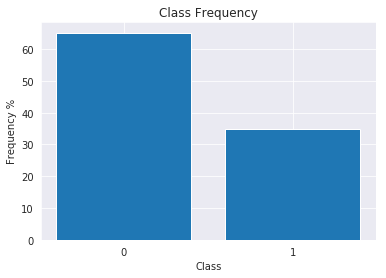

In [27]:
plt.bar(unique.astype(np.character),100*counts/classes_train.size)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency %')

In [28]:
#::GMG::A little more imabalanced in test dataset (should I care?)
classes_test = test.Outcome.values
unique, counts = np.unique(classes_test, return_counts = True)

Text(0, 0.5, 'Frequency %')

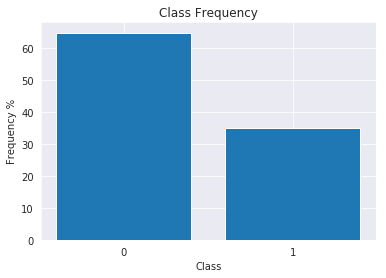

In [29]:
plt.bar(unique.astype(np.character),100*counts/classes_test.size)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency %')

## Pre-processing

### Outliers

In [20]:
#::GMG::Unexpected outliers, as I've just said from data.describe() ...
#       Glucose, Insulin, BloodPressure, SkinThickness, and BMI 
#       which have zeros (min) in their values
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
print("Zero Plasma Glucose  Total : ", data[data.Glucose == 0].shape[0])
print("Zero Insulin level   Total : ", data[data.Insulin == 0].shape[0])
print("Zero Blood Pressure  Total : ", data[data.BloodPressure == 0].shape[0])
print("Zero Skin Thickness  Total : ", data[data.SkinThickness == 0].shape[0])
print("Zero Body Mass Index Total : ", data[data.BMI == 0].shape[0])

Zero Plasma Glucose  Total :  5
Zero Insulin level   Total :  374
Zero Blood Pressure  Total :  35
Zero Skin Thickness  Total :  227
Zero Body Mass Index Total :  11


In [21]:
#::GMG::Hard choice to make ... remove the rows where the “BloodPressure”, 
#       “BMI” and “Glucose” are zero (small number of rows, low impact)
data_mod = data[(data.BloodPressure != 0) & 
                (data.BMI != 0) & 
                (data.Glucose != 0)
               ]

In [22]:
print(data_mod.shape)

(724, 9)


**::GMG::** The problem with `Insulin` and `Skin Thickness` is that they are a significant part of the dataset. They cannot be removed. I may use **an imputation method** to fill in the zeros, i.e. put *average/mean values*, but in this case putting a mean value to the blood pressure column *would send a wrong signal to the model*. I may also **avoid using the features** involved. Feature selection by filtering might come in handy and help with that. But the filter is going to use the *outliered* feature ... so I'm in doubt here!

In [23]:
#::GMG::Some basic (Pearson) correlations with Outcome
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
correlation_matrix = data_mod.corr()
correlation_matrix['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.488384
BMI                         0.299375
Age                         0.245741
Pregnancies                 0.224417
DiabetesPedigreeFunction    0.184947
BloodPressure               0.166703
Insulin                     0.145488
SkinThickness               0.092030
Name: Outcome, dtype: float64

**::GMG::** Based on this basic analysis I might avoid using `Skin Thickness` but not `Insulin` .

**::NOTE::** I've [searched](https://www.google.com/search?client=firefox-b-d&q=a+person+can+have+zero+insulin%3F) about this *zero insulin issue*. So [it turns out](https://www.yourhormones.info/hormones/insulin/) that

> People with type 1 diabetes produce very little or no insulin at all. This condition is caused when the beta cells that make insulin have been destroyed by antibodies (these are usually substances released by the body to fight against infections), hence they are unable to produce insulin.

In [24]:
#::GMG::I make a bold choice ...
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
data_final = data_mod.drop(columns = ['SkinThickness'])
print(data_final.shape)

(724, 8)


### Scale

## Logit Classifier

### model

In [28]:
#::GMG::I must tell the solver I want, otherwise it yields:
#
#        'FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. 
#         Specify a solver to silence this warning. FutureWarning)'
#
# when doing model.fit()
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# 'For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster 
#  for large ones.'
lr = LogisticRegression(solver = 'liblinear', random_state = 1)

### fit and predict

In [36]:
#::GMG::Split features/target in train and test
train_features = train.iloc[:,:train.shape[1] - 1]
train_target = train['Outcome']

In [37]:
train_features.shape

(506, 7)

In [38]:
train_target.shape

(506,)

In [39]:
test_features = test.iloc[:,:test.shape[1] - 1]
test_target = test['Outcome']

In [40]:
test_features.shape

(218, 7)

In [41]:
test_target.shape

(218,)

In [42]:
#::GMG::Train the model, default parameters except solver to avoid warning ;)
lr.fit(X = train_features, y = train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
#::GMG::Let's see the training accuracy. I've done some formatting
# https://pyformat.info/#number
# https://www.python-course.eu/python3_formatted_output.php
print('{:4.3f}'.format(
    lr.score(X = train_features, y = train_target)))

0.767


In [44]:
#::GMG::Now it's time to predict
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
pred = lr.predict(X = test_features)

In [45]:
print('{:4.3f}'.format(
    lr.score(X = test_features, y = test_target)))

0.780


### evaluation

In [46]:
#::GMG::Let's see the test accuracy (same as lr.score)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
#::GMG::I may use the lr model object to get the same score (accuracy)
#print('{:4.3f}'.format(
#    lr.score(X = test_features, y = test_target)))
print('Accuracy: {:4.3f}'.format(accuracy_score(test_target, pred)))

Accuracy: 0.780


In [47]:
#::GMG::Now sensitivity (aka recall) and specificity (biomed context like this one)
#       from the confusion matrix
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity
# https://stackoverflow.com/questions/33275461/specificity-in-scikit-learn
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
cm = confusion_matrix(y_true = test_target, y_pred = pred)
tn, fp, fn, tp = cm.ravel()
print(cm)

[[127  12]
 [ 36  43]]


In [48]:
tn, fp, fn, tp

(127, 12, 36, 43)

In [49]:
#::GMG::Specificity measures the proportion of actual negatives that are correctly identified 
#       as such (e.g., the percentage of healthy people who are correctly identified 
#       as not having the condition)
specificity = tn / (tn + fp)
#::GMG::The Sensitivity/Recall is intuitively the ability of the classifier to find all 
#       the positive samples (diabetes), e.g. the percentage of sick people who are correctly 
#       identified as having the condition
sensitivity = tp / (tp + fn)
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity
print('Specificity: {:4.3f} \nSensitivity/Recall: {:4.3f}'.format(
    specificity, sensitivity
    )
)

Specificity: 0.914 
Sensitivity/Recall: 0.544


In [50]:
#::GMG::The precision is intuitively the ability of the classifier not to label as positive 
#       a sample that is negative.
#::GMG::The recall is intuitively the ability of the classifier to find all 
#       the positive samples (diabetes)
# https://en.wikipedia.org/wiki/Precision_and_recall
# https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures
print('Precision: {:4.3f} \nRecall: {:4.3f}'.format(
    precision_score(y_true = test_target, y_pred = pred),
    recall_score(y_true = test_target, y_pred = pred)
    )
)

Precision: 0.782 
Recall: 0.544


In [51]:
#::GMG::F1 score of the positive (diabetes) class
# F1 = 2 * (precision * recall) / (precision + recall)
# https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
print('f_1 score (diabetes): {:4.3f} \nf_1 score (healthy): {:4.3f}'.format(
    f1_score(average = 'binary', pos_label = 1,
             y_true = test_target, y_pred = pred),
    f1_score(average = 'binary', pos_label = 0,
             y_true = test_target, y_pred = pred)
    )
)

f_1 score (diabetes): 0.642 
f_1 score (healthy): 0.841


In [53]:
#::GMG:: It is the macro-average of recall scores per class or, equivalently, 
#        raw accuracy where each sample is weighted according to the inverse prevalence 
#        of its true class. Thus for balanced datasets, the score is equal to accuracy.
print('Balanced Accuracy Score: {:4.3f}'.format(
    balanced_accuracy_score(y_true = test_target, y_pred = pred)))

Balanced Accuracy Score: 0.729


In [55]:
target_names = ['healthy', 'diabetes']
print(classification_report(y_true = test_target, y_pred = pred, 
                            target_names=target_names, digits = 3))

              precision    recall  f1-score   support

     healthy      0.779     0.914     0.841       139
    diabetes      0.782     0.544     0.642        79

   micro avg      0.780     0.780     0.780       218
   macro avg      0.780     0.729     0.741       218
weighted avg      0.780     0.780     0.769       218



In [59]:
#::GMG::AUC (imbalanced dataset -> average = 'weighted')
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
# 'weighted': Calculate metrics for each label, and find their average, weighted by 
#             support (the number of true instances for each label)
probs = lr.predict_proba(X = test_features)
prob = probs[:, 1] 
auc = roc_auc_score(y_true = test_target, y_score = prob, average = 'weighted')
print('AUC diabetes: {:4.3f}'.format(auc))

AUC diabetes: 0.823


In [109]:
#::GMG::ROC
# https://stackabuse.com/understanding-roc-curves-with-python/
# https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics
# https://stackoverflow.com/questions/2891790/how-to-pretty-print-a-numpy-array-without-scientific-notation-and-with-given-pre
fpr, tpr, thresholds = roc_curve(
    y_true = test_target, 
    y_score = prob, 
    pos_label = 1
)
print('fpr: {} \ntpr: {} \nthresholds: {}'.format(
    np.array_str(a = fpr, precision = 3), 
    np.array_str(a = tpr, precision = 3), 
    np.array_str(a = thresholds, precision = 3)
    )
)

fpr: [0.    0.007 0.007 0.014 0.014 0.022 0.022 0.029 0.029 0.036 0.036 0.043
 0.043 0.05  0.05  0.058 0.058 0.079 0.079 0.086 0.086 0.115 0.115 0.122
 0.122 0.151 0.151 0.165 0.165 0.173 0.173 0.18  0.18  0.245 0.245 0.259
 0.259 0.324 0.324 0.374 0.374 0.41  0.41  0.554 0.554 0.583 0.583 0.59
 0.59  0.633 0.633 0.662 0.662 0.676 0.676 0.712 0.712 0.791 0.791 1.   ] 
tpr: [0.    0.    0.076 0.076 0.152 0.152 0.177 0.177 0.316 0.316 0.38  0.38
 0.405 0.405 0.418 0.418 0.43  0.43  0.456 0.456 0.582 0.582 0.62  0.62
 0.658 0.658 0.709 0.709 0.734 0.734 0.747 0.747 0.759 0.759 0.772 0.772
 0.797 0.797 0.81  0.81  0.823 0.823 0.835 0.835 0.848 0.848 0.899 0.899
 0.924 0.924 0.937 0.937 0.949 0.949 0.975 0.975 0.987 0.987 1.    1.   ] 
thresholds: [1.952 0.952 0.862 0.85  0.768 0.758 0.753 0.752 0.657 0.648 0.612 0.612
 0.592 0.592 0.589 0.557 0.556 0.547 0.541 0.536 0.492 0.464 0.445 0.437
 0.428 0.403 0.384 0.359 0.346 0.345 0.343 0.333 0.331 0.3   0.296 0.294
 0.289 0.27  0.269 0.252 0.2

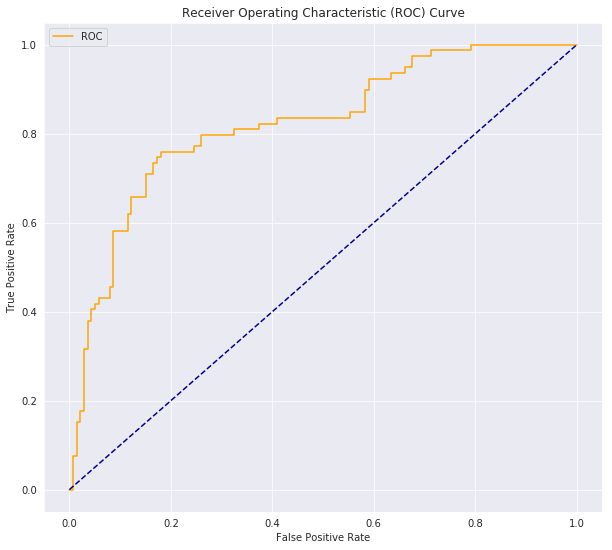

In [83]:
#::GMG::Plot ROC
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
plt.figure(figsize = (10,9))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

In [89]:
#::GMG::Precision-Recall Curve and AUC, and average precision are better metrics 
#       with an imbalanced dataset
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
apc = average_precision_score(y_true = test_target, 
                              y_score = prob, 
                              pos_label = 1, 
                              average = 'weighted')
print('Average Precision Weighted: {:4.3f}'.format(apc))

Average Precision Weighted: 0.717


In [96]:
#::GMG::Precision-Reacall Curve
precision, recall, thresholds_pr = precision_recall_curve(
    y_true = test_target, 
    probas_pred = prob, 
    pos_label = 1
)
print('precision: {} \nrecall: {} \nthresholds: {}'.format(
    np.array_str(a = precision, precision = 3), 
    np.array_str(a = recall, precision = 3), 
    np.array_str(a = thresholds_pr, precision = 3)
    )
)

precision: [0.418 0.415 0.417 0.419 0.422 0.424 0.426 0.429 0.431 0.433 0.436 0.438
 0.441 0.438 0.44  0.443 0.445 0.448 0.45  0.447 0.444 0.446 0.449 0.446
 0.448 0.451 0.454 0.457 0.453 0.456 0.459 0.462 0.465 0.468 0.471 0.468
 0.464 0.467 0.464 0.46  0.456 0.453 0.456 0.459 0.462 0.465 0.462 0.465
 0.468 0.471 0.475 0.478 0.482 0.485 0.489 0.493 0.496 0.5   0.504 0.508
 0.512 0.516 0.52  0.524 0.528 0.532 0.537 0.533 0.537 0.542 0.546 0.551
 0.556 0.552 0.557 0.561 0.566 0.571 0.577 0.582 0.587 0.583 0.589 0.594
 0.6   0.606 0.612 0.618 0.624 0.63  0.636 0.633 0.629 0.635 0.642 0.638
 0.645 0.652 0.659 0.667 0.674 0.682 0.69  0.698 0.706 0.702 0.711 0.707
 0.716 0.713 0.709 0.718 0.727 0.724 0.72  0.716 0.712 0.722 0.732 0.743
 0.754 0.75  0.746 0.742 0.754 0.75  0.746 0.742 0.754 0.767 0.78  0.793
 0.789 0.786 0.782 0.778 0.774 0.769 0.765 0.76  0.755 0.75  0.766 0.761
 0.756 0.773 0.791 0.81  0.805 0.825 0.821 0.842 0.838 0.833 0.857 0.853
 0.848 0.844 0.839 0.833 0.862 0.857 0.8

In [98]:
#::GMG::AUC (recall, precision)
auc_pr = auc(x = recall, y = precision)
print('AUC Precision/Recall: {:4.3f}'.format(auc_pr))

AUC Precision/Recall: 0.709


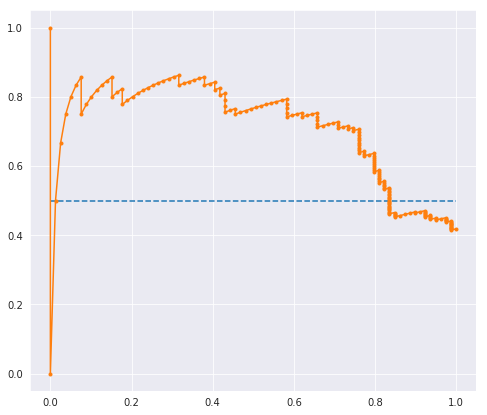

In [108]:
#::GMG::Plot Precision Recall Curve
#::NOTE::It's a bit strange curve with that zero glitch at the beginning!
plt.figure(figsize = (8,7))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.72')

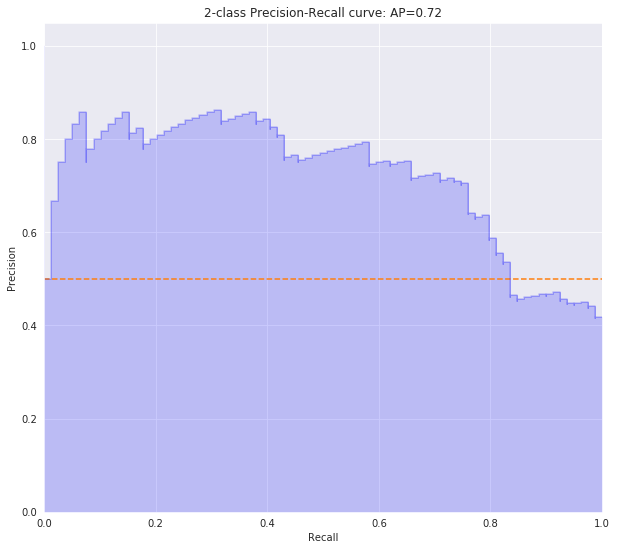

In [106]:
#::GMG::Alternatve plot from
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from inspect import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(figsize = (10,9))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color = 'C1')
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(apc))

### balanced model

In [70]:
#::GMG::class_weight : dict or ‘balanced’, optional (default=None)
#       The “balanced” mode uses the values of y to automatically adjust weights inversely 
#       proportional to class frequencies in the input data as 
#       n_samples / (n_classes * np.bincount(y))
#
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lr_bm = LogisticRegression(solver = 'liblinear', 
                           class_weight = 'balanced', 
                           random_state = 2)

### fit and predict

In [71]:
#::GMG::Train the model
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit
#
# sample_weight : array-like, shape (n_samples,) optional
lr_bm.fit(X = train_features, y = train_target)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [72]:
#::GMG::Now it's time to predict
pred_bm = lr_bm.predict(X = test_features)

In [73]:
#::GMG::Scores
print('Score Train: {:4.3f} \nScore Test: {:4.3f}'.format(
    lr_bm.score(X = train_features, y = train_target),
    lr_bm.score(X = test_features, y = test_target)
    )
)

Score Train: 0.761 
Score Test: 0.794


### evaluation

In [74]:
#::GMG::Report
print(classification_report(y_true = test_target, y_pred = pred_bm, 
                            target_names=target_names, digits = 3))

              precision    recall  f1-score   support

     healthy      0.846     0.827     0.836       139
    diabetes      0.707     0.734     0.720        79

   micro avg      0.794     0.794     0.794       218
   macro avg      0.776     0.781     0.778       218
weighted avg      0.795     0.794     0.794       218



In [75]:
#::GMG::Confusion Matrix
cm_bm = confusion_matrix(y_true = test_target, y_pred = pred_bm)
print(cm_bm)

[[115  24]
 [ 21  58]]


In [76]:
#::GMG::AUC
probs_bm = lr_bm.predict_proba(X = test_features)
prob_bm = probs_bm[:, 1] 
auc_bm = roc_auc_score(y_true = test_target, y_score = prob_bm, average = 'weighted')
print('AUC diabetes: {:4.3f} \nAUC Balanced Mode diabetes: {:4.3f}'.format(auc, auc_bm))

AUC diabetes: 0.823 
AUC Balanced Mode diabetes: 0.825


In [110]:
#::GMG::ROC curve
fpr_bm, tpr_bm, thresholds_bm = roc_curve(
    y_true = test_target, 
    y_score = prob_bm, 
    pos_label = 1
)
print('fpr: {} \ntpr: {} \nthresholds: {}'.format(
    np.array_str(a = fpr_bm, precision = 3), 
    np.array_str(a = tpr_bm, precision = 3), 
    np.array_str(a = thresholds_bm, precision = 3)
    )
)

fpr: [0.    0.007 0.007 0.014 0.014 0.022 0.022 0.029 0.029 0.036 0.036 0.05
 0.05  0.058 0.058 0.072 0.072 0.086 0.086 0.094 0.094 0.122 0.122 0.129
 0.129 0.137 0.137 0.144 0.144 0.151 0.151 0.158 0.158 0.173 0.173 0.259
 0.259 0.266 0.266 0.273 0.273 0.281 0.281 0.388 0.388 0.417 0.417 0.518
 0.518 0.525 0.525 0.547 0.547 0.561 0.561 0.583 0.583 0.59  0.59  0.633
 0.633 0.655 0.655 0.669 0.669 0.755 0.755 0.777 0.777 1.   ] 
tpr: [0.    0.    0.076 0.076 0.139 0.139 0.152 0.152 0.291 0.291 0.38  0.38
 0.418 0.418 0.43  0.43  0.443 0.443 0.582 0.582 0.595 0.595 0.646 0.646
 0.658 0.658 0.671 0.671 0.684 0.684 0.696 0.696 0.734 0.734 0.759 0.759
 0.772 0.772 0.785 0.785 0.797 0.797 0.81  0.81  0.823 0.823 0.835 0.835
 0.848 0.848 0.861 0.861 0.886 0.886 0.899 0.899 0.911 0.911 0.924 0.924
 0.937 0.937 0.962 0.962 0.975 0.975 0.987 0.987 1.    1.   ] 
thresholds: [1.977 0.977 0.93  0.924 0.887 0.878 0.877 0.864 0.801 0.799 0.766 0.754
 0.734 0.726 0.721 0.716 0.708 0.699 0.646 0.637 0.

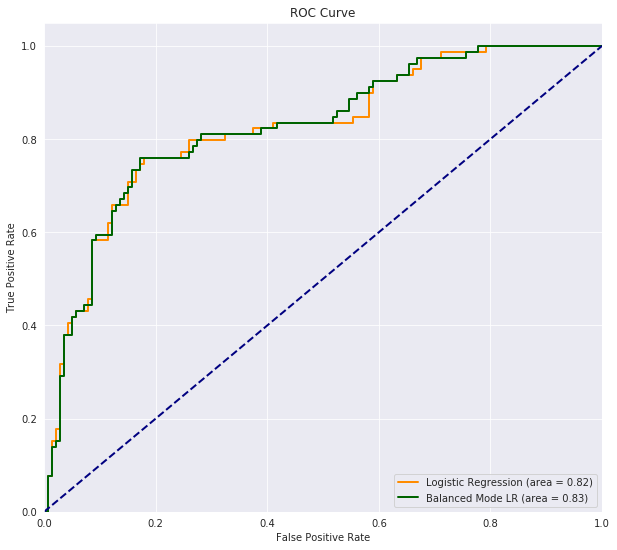

In [84]:
#::GMG::Plot ROC curve
plt.figure(figsize = (10,9))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot(fpr_bm, tpr_bm, color='darkgreen',
         lw=2, label='Balanced Mode LR (area = %0.2f)' % auc_bm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [111]:
#::GMG::average precision 
apc_bm = average_precision_score(y_true = test_target, 
                                 y_score = prob_bm, 
                                 pos_label = 1, 
                                 average = 'weighted')
print('Average Precision Weighted: {:4.3f}'.format(apc_bm))

Average Precision Weighted: 0.716


In [112]:
#::GMG::Precision-Recall Curve
precision_bm, recall_bm, _ = precision_recall_curve(
    y_true = test_target, 
    probas_pred = prob_bm, 
    pos_label = 1
)

In [113]:
#::GMG::AUC (precision, recall)
auc_pr_bm = auc(x = recall_bm, y = precision_bm)
print('AUC Precision/Recall: {:4.3f}'.format(auc_pr_bm))

AUC Precision/Recall: 0.708


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.72')

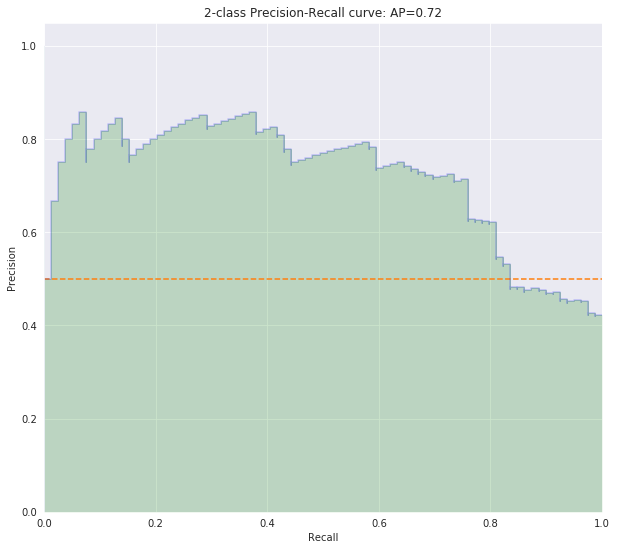

In [114]:
#::GMG::Plot Recall-Precision Curve
plt.figure(figsize = (10,9))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color = 'C1')
plt.step(recall_bm, precision_bm, color='b', alpha=0.2, where='post')
plt.fill_between(recall_bm, precision_bm, alpha=0.2, color='g', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(apc_bm))